Original paper: https://arxiv.org/abs/1806.00035

# 0. Read real and generated images#

In [1]:
import math
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import matplotlib

In [2]:
CHANNEL_NUM = 3
PICTURE_SIZE = 36


In [3]:
class ParticleDataset():
    def __init__(self, file):
        self.data = np.load(file)
        self.image = self.data['Pictures'].reshape(-1, CHANNEL_NUM*PICTURE_SIZE*PICTURE_SIZE)

    def __len__(self):
        return len(self.image)

    def __getitem__(self, i):
        return {
            "Pictures": self.image[i],
        }

In [4]:
real_data = ParticleDataset('real.npz')
vae_data = ParticleDataset('vae.npz')
gan_data = ParticleDataset('gan.npz')

Make sure that the values of real and generated data are of the same order - it is important for cooperative binarizing

In [5]:
print (np.min(real_data.image), np.max(real_data.image))
print (np.min(gan_data.image), np.max(gan_data.image))
print (np.min(vae_data.image), np.max(vae_data.image))

0.0 1.0
0.0 1.0
0.00016965241 0.9797329


# 1. Binarize# 

To understand how real and generated objects are close to each other, we need to choose a space of features in which we look these objects at

We go the easiest way and take pixels' values as features.

In [6]:
# adapted some parts from https://github.com/msmsajjadi/precision-recall-distributions

from sklearn.cluster import KMeans, MiniBatchKMeans
import math
## function which map object to probability distribution ##

def bin_counts(real_data, generated_data, number_of_bins=25):
    # binirize real and generated data, plot histogram and found density function
    data_both = np.concatenate((real_data, generated_data))
    data_labels = MiniBatchKMeans(n_clusters=number_of_bins).fit(data_both).labels_
    real_labels = data_labels[:len(real_data)]
    generated_labels = data_labels[len(real_data):]
    real_density = np.histogram(real_labels, bins=number_of_bins, range=[0, number_of_bins], density=True)[0]
    gen_density = np.histogram(generated_labels, bins=number_of_bins, range=[0, number_of_bins], density=True)[0]
    return real_density, gen_density

Create $\alpha-$ and $\beta-$ vectors as in

$\hat{PRD}(Q,P) = \{(\alpha(\lambda), \beta(\lambda))| \lambda \in \Lambda \}$, where $\Lambda = \{\tan (\frac{i}{m+1} \frac{\pi}{2}) | i = 1, 2 ... m\}$

In [7]:
def count_alpha_beta(real_density, gen_density, num_angles = 1000):
    assert real_density.shape == gen_density.shape
    alpha_vec = []
    beta_vec = []
    angles = np.linspace(1e-6, np.pi/2 - 1e-6, num=num_angles)
    for lam in np.tan(angles):
        alpha_vec.append(np.minimum(lam * real_density, gen_density).sum())
        beta_vec.append(np.minimum(real_density, gen_density / lam).sum())
    return alpha_vec, beta_vec

For stability, take the average of several repetitions

In [8]:
def count_prd(reals, gens, repeat_number = 10):
    vectors = [count_alpha_beta(reals, gens) for i in range(repeat_number)]
    vectors = np.array(vectors).mean(axis=0)
    print(vectors.shape)
    return vectors

## 2. Apply it##

In [9]:
a, b = bin_counts(real_data.image, vae_data.image)
c, d = bin_counts(real_data.image, gan_data.image)

## 3. Make vectors for plot and plot ##

In [10]:
data_for_plots = count_prd(a, b)
data_for_plots2 = count_prd(c, d)

(2, 1000)
(2, 1000)


In [13]:
a

array([5.56950468e-02, 6.08689036e-04, 4.18473712e-02, 7.70752492e-02,
       6.21623678e-02, 6.73362246e-02, 0.00000000e+00, 7.60861295e-05,
       1.03401050e-01, 4.58038500e-02, 0.00000000e+00, 1.52172259e-04,
       7.79121966e-02, 4.51951609e-02, 2.96735905e-02, 4.71734003e-02,
       6.89340333e-02, 8.36186563e-02, 0.00000000e+00, 4.56516777e-04,
       3.46952751e-02, 6.92383778e-02, 1.43802785e-02, 2.09997717e-02,
       5.35646352e-02])

In [14]:
b

array([0.00000000e+00, 1.11770524e-01, 0.00000000e+00, 0.00000000e+00,
       4.56516777e-04, 0.00000000e+00, 1.30944229e-01, 1.05759720e-01,
       0.00000000e+00, 0.00000000e+00, 1.36574602e-01, 1.36650689e-01,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 7.60861295e-05, 2.03834741e-01, 1.14813969e-01,
       0.00000000e+00, 0.00000000e+00, 5.63798220e-02, 0.00000000e+00,
       2.73910066e-03])

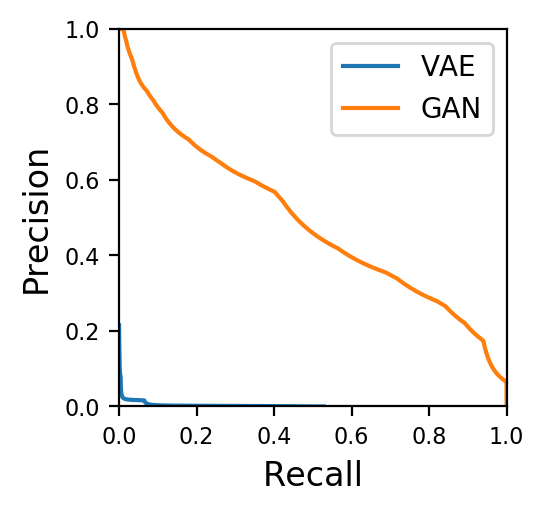

In [11]:
fig = plt.figure(figsize=(2.5, 2.5), dpi=200)
fig.add_subplot(111).tick_params(axis='both', which='major', labelsize=8)
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.xlabel('Recall', fontsize=12)
plt.ylabel('Precision', fontsize=12)
plt.plot(data_for_plots[0], data_for_plots[1], label = "VAE")
plt.plot(data_for_plots2[0], data_for_plots2[1], label = "GAN")
plt.legend()
plt.show()

**What curves were obtained for the first(VAE) and the second(GAN) models? What can we say about the advantages and disadvantages of each model?**

According to the plot, we may see that in the current task GANs show themselves a lot better than VAEs.

## Bonus: about features' space##

It is possible to transfer the picture-> embedding, for example, using the 1st part of the Inception network as a feature extraxtor. This embedding can be used for bin counts also

In [ ]:
# if you came here and still alive, the implementation of idea above will give you extra points =)